In [52]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

from time import time
from tensorflow.keras.models import Sequential, load_model, model_from_json
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, LSTM, Embedding, Reshape
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split

import os

from urllib.request import urlretrieve

from os import mkdir, makedirs, remove, listdir

from collections import Counter

from python_utils import *

Solving environment: done

# All requested packages already installed.



In [2]:
#Glove vector data 
with open('glove.6B/glove.6B.50d.txt','rb') as f:
    lines = f.readlines()
    
glove_weights = np.zeros((len(lines), 50))
words = []
for i, line in enumerate(lines):
    word_weights = line.split()
    words.append(word_weights[0])
    weight = word_weights[1:]
    glove_weights[i] = np.array([float(w) for w in weight])
word_vocab = [w.decode("utf-8") for w in words]

word2glove = dict(zip(word_vocab, glove_weights))

In [3]:
# from tensorflow.keras.layers import Layer
# import tensorflow.keras.backend as K
# from tensorflow.keras import initializers
# import numpy as np

# class Embedding2(Layer):

#     def __init__(self, input_dim, output_dim, fixed_weights, embeddings_initializer='uniform', 
#                  input_length=None, **kwargs):
#         kwargs['dtype'] = 'int32'
#         if 'input_shape' not in kwargs:
#             if input_length:
#                 kwargs['input_shape'] = (input_length,)
#             else:
#                 kwargs['input_shape'] = (None,)
#         super(Embedding2, self).__init__(**kwargs)
    
#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.embeddings_initializer = embeddings_initializer
#         self.fixed_weights = fixed_weights
#         self.num_trainable = input_dim - len(fixed_weights)
#         self.input_length = input_length
        
#         w_mean = fixed_weights.mean(axis=0)
#         w_std = fixed_weights.std(axis=0)
#         self.variable_weights = w_mean + w_std*np.random.randn(self.num_trainable, output_dim)

#     def build(self, input_shape, name='embeddings'):        
#         fixed_weight = K.variable(self.fixed_weights, name=name+'_fixed')
#         variable_weight = K.variable(self.variable_weights, name=name+'_var')
        
#         self._trainable_weights.append(variable_weight)
#         self._non_trainable_weights.append(fixed_weight)
        
#         self.embeddings = K.concatenate([fixed_weight, variable_weight], axis=0)
        
#         self.built = True

#     def call(self, inputs):
#         if K.dtype(inputs) != 'int32':
#             inputs = K.cast(inputs, 'int32')
#         out = K.gather(self.embeddings, inputs)
#         return out

#     def compute_output_shape(self, input_shape):
#         if not self.input_length:
#             input_length = input_shape[1]
#         else:
#             input_length = self.input_length
#         return (input_shape[0], input_length, self.output_dim)

In [63]:
df = pd.read_csv('liar_dataset/test.tsv', delimiter = '\t' ,encoding = 'utf-8')
df.columns = ['ID', 'label', 'statement','subjects','speaker','speakersJobTitle', 'state_info', 'party_afflin','bt_c', 'f_c', 'ht_c', 'mt_c', 'pof_c', 'context']
df.ID = df.ID.str.lower()
df.statement = df.statement.str.lower()
df.subjects = df.subjects.str.lower()
df.speaker = df.speaker.str.lower()
df.speakersJobTitle = df.speakersJobTitle.str.lower()
df.state_info = df.state_info.str.lower()
df.party_afflin = df.party_afflin.str.lower()

In [64]:
df.drop('ID', axis = 1, inplace = True)

In [65]:
df.head()

,label,statement,subjects,speaker,speakersJobTitle,state_info,party_afflin,bt_c,f_c,ht_c,mt_c,pof_c,context
0,false,wisconsin is on pace to double the number of l...,jobs,katrina-shankland,state representative,wisconsin,democrat,2,1,0,0,0,a news conference
1,false,says john mccain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,president-elect,new york,republican,63,114,51,37,61,comments on ABC's This Week.
2,half-true,suzanne bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,oregon,republican,1,1,3,1,1,a radio show
3,pants-fire,when asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,wisconsin,democrat,5,7,2,2,7,a web video
4,true,over the past five years the federal governmen...,"federal-budget,pensions,retirement",brendan-doherty,NaN,rhode island,republican,1,2,1,1,0,a campaign website


In [66]:
#creating a list where words are converted into ints
all_text = ' '.join(df.statement.values)
words = all_text.split()
u_words = Counter(words).most_common()           #in the form of [('the', 1208), ('<word>', <count>), ...]
u_words_counter = u_words
u_words_frequent = [word[0] for word in u_words if word[1] > 5]      #in the form of ['the', '<word>', ...]

u_words_total = [k for k,v in u_words_counter]                       #in the form of ['the', '<word>', ...]
word_vocab = dict(zip(word_vocab, range(len(word_vocab))))           #in the form of {'the':<num>, ...}
word_in_glove = np.array([w in word_vocab for w in u_words_total])   

words_in_glove = [w for w,is_true in zip(u_words_total,word_in_glove) if is_true]   #[True, False, False ..] array
words_not_in_glove = [w for w,is_true in zip(u_words_total,word_in_glove) if not is_true]


print('Fraction of unique words in glove vectors: ', sum(word_in_glove)/len(word_in_glove))

# # create the dictionary
word2num = dict(zip(words_in_glove,range(len(words_in_glove))))
len_glove_words = len(word2num)
freq_words_not_glove = [w for w in words_not_in_glove if w in u_words_frequent]
b = dict(zip(freq_words_not_glove,range(len(word2num), len(word2num)+len(freq_words_not_glove))))
word2num = dict(**word2num, **b)
word2num['<Other>'] = len(word2num)
num2word = dict(zip(word2num.values(), word2num.keys()))

int_text = [[word2num[word] if word in word2num else word2num['<Other>'] 
             for word in content.split()] for content in df.statement.values]

print('The number of unique words are: ', len(u_words))
print('The first review looks like this: ')
print(int_text[0][:20])
print('And once this is converted back to words, it looks like: ')
print(' '.join([num2word[i] for i in int_text[0][:20]]))


Fraction of unique words in glove vectors:  0.6779039301310044
The number of unique words are:  5725
The first review looks like this: 
[112, 8, 10, 1690, 3, 797, 0, 204, 2, 1691, 36, 3883]
And once this is converted back to words, it looks like: 
wisconsin is on pace to double the number of layoffs this year.


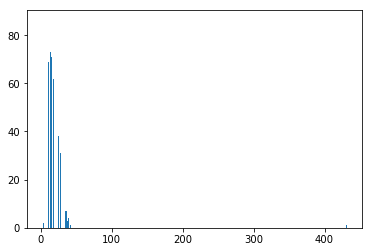

In [69]:
plt.hist([len(t) for t in int_text], bins = 1000)
plt.show()

In [9]:
print('The number of articles greater than 50 in length is: ', np.sum(np.array([len(t)>25 for t in int_text])))
print('The number of articles less than 10 in length is: ', np.sum(np.array([len(t)<8 for t in int_text])))

The number of articles greater than 50 in length is:  211
The number of articles less than 10 in length is:  59


In [10]:
num2word[len(word2num)] = '<PAD>'
word2num['<PAD>'] = len(word2num)

for i, t in enumerate(int_text):
    if len(t)<25:
        int_text[i] = [word2num['<PAD>']]*(25-len(t)) + t
    elif len(t)>25:
        int_text[i] = t[:25]
    else:
        continue

x = np.array(int_text)
y = (df.label.values=='true').astype('int')

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [11]:
df[df.label == 'true'].statement.values[0]

'over the past five years the federal government has paid out $601 million in retirement and disability benefits to deceased former federal employees.'

In [12]:
df[df.label == 'pants-fire'].statement.values[0]

'when asked by a reporter whether hes at the center of a criminal scheme to violate campaign laws, gov. scott walker nodded yes.'

In [57]:
model = Sequential()
model.add(Embedding(len(word2num), 50))
model.add(LSTM(64))

model.add(Dense(1, activation = 'sigmoid'))

tensorboard = TensorBoard(log_dir = "logs/{}".format(time()))

model.compile(loss = 'MSE', optimizer = 'rmsprop', metrics = ['accuracy'])


model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 50)          196150    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 225,655
Trainable params: 225,655
Non-trainable params: 0
_________________________________________________________________


In [58]:
batch_size = 64
epochs = 10
v = 0
for i in range(epochs):
    if i % (epochs//10) == 0 or i == epochs - 1:
        v = 1
        print('Epoch ',i+1,'/',epochs)
        
    model.fit(X_train, y_train, batch_size=batch_size, epochs=1, validation_data=(X_test, y_test),verbose=v, callbacks=[tensorboard])
    v = 0

Epoch  1 / 10
Train on 1139 samples, validate on 127 samples
1139/1139 [==============================] - 37s 33ms/sample - loss: 0.1654 - accuracy: 0.8086 - val_loss: 0.1128 - val_accuracy: 0.8740
Epoch  2 / 10
Train on 1139 samples, validate on 127 samples
1139/1139 [==============================] - 22s 19ms/sample - loss: 0.1399 - accuracy: 0.8323 - val_loss: 0.1103 - val_accuracy: 0.8740
Epoch  3 / 10
Train on 1139 samples, validate on 127 samples
1139/1139 [==============================] - 23s 20ms/sample - loss: 0.1374 - accuracy: 0.8323 - val_loss: 0.1120 - val_accuracy: 0.8740
Epoch  4 / 10
Train on 1139 samples, validate on 127 samples
1139/1139 [==============================] - 22s 19ms/sample - loss: 0.1324 - accuracy: 0.8323 - val_loss: 0.1161 - val_accuracy: 0.8740
Epoch  5 / 10
Train on 1139 samples, validate on 127 samples
1139/1139 [==============================] - 22s 19ms/sample - loss: 0.1106 - accuracy: 0.8341 - val_loss: 0.1261 - val_accuracy: 0.8740
Epoch  6 /

In [60]:
sentence = "Says the unemployment rate for college graduates is 4.4 percent and over 10 percent for noncollege-educated.".lower()
sentence_num = [word2num[w] if w in word2num else word2num['<Other>'] for w in sentence.split()]
sentence_num = [word2num['<PAD>']]*(25-len(sentence_num)) + sentence_num
sentence_num = np.array(sentence_num)
model.predict(sentence_num[None,:])

array([[0.0124297]], dtype=float32)

In [27]:
# model = Sequential()
# model.add(Embedding2(len(word2num), 50,
#                     fixed_weights=np.array([word2glove[w] for w in words_in_glove])))

# model.add(LSTM(64))

# model.add(Dense(1, activation = 'sigmoid'))
# model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

# model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding2 (Embedding2)      (None, None, 50)          196150    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 225,655
Trainable params: 31,605
Non-trainable params: 194,050
_________________________________________________________________


In [28]:
batch_size = 64
model.fit(X_train, y_train, batch_size=batch_size, epochs=10, validation_data=(X_test, y_test))

Train on 1139 samples, validate on 127 samples
Epoch 1/10
1139/1139 [==============================] - 23s 20ms/sample - loss: 0.4734 - accuracy: 0.8253 - val_loss: 0.3828 - val_accuracy: 0.8740
Epoch 2/10
1139/1139 [==============================] - 19s 17ms/sample - loss: 0.4552 - accuracy: 0.8323 - val_loss: 0.3775 - val_accuracy: 0.8740
Epoch 3/10
1139/1139 [==============================] - 24s 21ms/sample - loss: 0.4516 - accuracy: 0.8323 - val_loss: 0.3745 - val_accuracy: 0.8740
Epoch 4/10
1139/1139 [==============================] - 20s 17ms/sample - loss: 0.4459 - accuracy: 0.8323 - val_loss: 0.3784 - val_accuracy: 0.8740
Epoch 5/10
1139/1139 [==============================] - 19s 17ms/sample - loss: 0.4439 - accuracy: 0.8323 - val_loss: 0.3674 - val_accuracy: 0.8740
Epoch 6/10
1139/1139 [==============================] - 19s 16ms/sample - loss: 0.4389 - accuracy: 0.8323 - val_loss: 0.3940 - val_accuracy: 0.8740
Epoch 7/10
1139/1139 [==============================] - 19s 16ms/

In [39]:
# sentence = "Says the unemployment rate for college graduates is 4.4 percent and over 10 percent for noncollege-educated.".lower()
# sentence_num = [word2num[w] if w in word2num else word2num['<Other>'] for w in sentence.split()]
# sentence_num = [word2num['<PAD>']]*(500-len(sentence_num)) + sentence_num
# sentence_num = np.array(sentence_num)
# model.predict(sentence_num[None,:])

array([[0.19414745]], dtype=float32)